In [2]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 33.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438508 sha256=c400bb5699e8286a3e803402251f2429b207bd50941365360ac7e488a6015425
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [40]:
%%writefile task5.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import timeit

start = timeit.default_timer()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

N_total = 1000
my_n = int(N_total/size)

def ReturnLastNValues(r = 2.0, x0 = 0.5, number_of_steps = 100, number_of_steps_return = 50):
    x = np.empty(0, dtype=np.float32)
    x = np.append(x, x0)
    for n in range(1, number_of_steps):
        x_new = r * x[n-1] * (1 - x[n - 1])
        x = np.append(x, x_new)

    return x[-1:-number_of_steps_return-1:-1]

r_total = np.linspace(0,4, N_total, endpoint=False)
#print('r_total', r_total.shape)
r_cur = r_total[rank*my_n:(rank+1)*my_n]
#print('r_cur',r_cur.shape)
x = []


for cur_r in r_cur:

    x.append(ReturnLastNValues(r=cur_r))
root = 0
x_global = comm.gather(x, root = root)

#TIME = timeit.default_timer() - start

#TIME_gen = comm.reduce(TIME, op=MPI.SUM, root = 0)

#print(TIME)
if rank == root:
    #print('final',TIME_gen/ size)
    x_global = np.array(x_global)
    print('x_global',x_global.shape)
    x_global = x_global.reshape((size*my_n, 50))
    print('x_global',x_global.shape)
    for i in range(size*my_n):
        plt.plot(np.ones(50)*r_total[i], x_global[i], 'k.', ms = 1)
    plt.savefig('test.png')

TIME = timeit.default_timer() - start

TIME_gen = comm.reduce(TIME, op=MPI.SUM, root = 0)
if rank == 0:
    print('final',TIME_gen/ size)

Overwriting task5.py


In [44]:
!mpirun --allow-run-as-root -n 2 python task5.py

x_global (2, 500, 50)
x_global (1000, 50)
0.39116784500038193
1.6608182739996664
final 1.0259930595000242


Text(0, 0.5, 'Speedup')

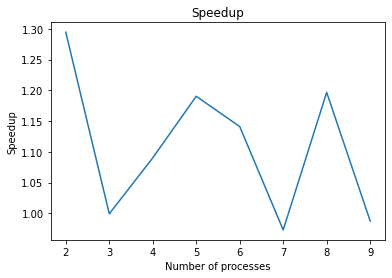

In [39]:
import numpy as np
import matplotlib.pyplot as plt
time_1_proc = 1.28378665799994

proc_time = np.array([
    0.9916731020000498,
    1.2848880300000094,
    1.1776019959999644,
    1.0784757963999936,
    1.12502224716665,
    1.3195018034285957,
    1.0727387073750236,
    1.2999079088889023
])

plt.plot(1+np.array(range(1,proc_time.shape[0]+1)), time_1_proc/proc_time)
plt.title('Speedup')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
# plt.savefig('speedup.png')